In [11]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
from datetime import datetime, timedelta

from sklearn import datasets, linear_model
from sklearn.cross_validation import cross_val_predict

from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pickle

In this notebook, we show how to estimate the produced solar power for each month at each weather station ny making use of the models created in the other notebook. We will make use of this power to estimate the produced power at the user's location.

# Load data

We load a DataFrame containing all irradiance means. This pickle file is not in the repository because of its large size.

In [13]:
irradMean_df = pickle.load(open('../idaWebData/irradMean_df.p', 'rb'))

In [14]:
irradMean_df.head(10)

,time,gre000z0
stn,,
TAE,200001010000,0
TAE,200001010010,0
TAE,200001010020,0
TAE,200001010030,0
TAE,200001010040,12
TAE,200001010050,0
TAE,200001010100,0
TAE,200001010110,0
TAE,200001010120,0


In [15]:
irradMean_df.tail()

,time,gre000z0
stn,,
KLO,201512312310,2
KLO,201512312320,2
KLO,201512312330,2
KLO,201512312340,2
KLO,201512312350,2


Here, `gre00z0` is the code for mean irradiance measurements in Idaweb.

# Pre-processing

Due to how the pickle file was created (concatenating all the irradiance measurements available into a DataFrame), some rows are actually headers of the files, thus we need to remove them.

In [17]:
irradMean_df = irradMean_df[irradMean_df.time != 'time']

In [18]:
irradMean_df.shape

(86535644, 2)

Next, we convert the time column into datetime format.

In [20]:
irradMean_df['time'] = pd.to_datetime(irradMean_df['time'], format='%Y%m%d%H%M')

In [21]:
irradMean_df.head()

,time,gre000z0
stn,,
TAE,2000-01-01 00:00:00,0
TAE,2000-01-01 00:10:00,0
TAE,2000-01-01 00:20:00,0
TAE,2000-01-01 00:30:00,0
TAE,2000-01-01 00:40:00,12


And we remove missing measurements ("-").

In [22]:
irradMean_df = irradMean_df[irradMean_df.gre000z0 != '-']

Furthermore, we convert the measurement column from string into numeric.

In [24]:
irradMean_df.gre000z0 = pd.to_numeric(irradMean_df.gre000z0)

In [25]:
type(irradMean_df.iloc[0]['gre000z0'])

numpy.int64

Finally, we remove noise from zero measurements (negative irradiance makes no sense).

In [24]:
irradMean_df.loc[irradMean_df.gre000z0 < 0, 'gre000z0'] = 0

# Grouping

For each station, we want the average for each month (over all years).

Firstly, we transform the time column into month only.

In [26]:
irradMean_df.time = irradMean_df.time.dt.month

In [27]:
irradMean_df.head()

,time,gre000z0
stn,,
TAE,1,0
TAE,1,0
TAE,1,0
TAE,1,0
TAE,1,12


And then we group by station and month.

In [28]:
irradMean_df.reset_index(inplace=True)

In [30]:
stn_month_irrad = irradMean_df.groupby(by=['stn','time'])

In [31]:
means = stn_month_irrad.mean()

In [32]:
means

gre000z0
stn    time            
ABO    1      58.048460
       2      96.532893
       3     149.232683
       4     184.433614
       5     202.537315
       6     223.920250
       7     215.322667
       8     190.238898
       9     155.390976
       10    101.868912
       11     61.735498
       12     48.092217
AIG    1      53.937064
       2      91.366564
       3     147.649500
       4     190.951733
       5     214.986601
       6     253.297507
       7     240.113136
       8     206.868041
       9     165.974634
       10    105.705504
       11     61.668927
       12     44.891603
ALT    1      40.979850
       2      78.639340
       3     132.764949
       4     182.079959
       5     204.094546
       6     221.921360
...                 ...
WSLVSF 7     266.251388
       8     227.773566
       9     180.596759
       10    111.264664
       11     41.818263
       12     17.613502
WYN    1      37.802419
       2      76.178236
       3     130.907019
       4     177.085490
       5     212.425709
       6     248.632634
       7     239.195900
       8     203.215712
       9     148.039229
       10     82.179712
       11     43.814406
       12     30.036514
ZER    1      64.380734
       2     109.065261
       3     167.447288
       4     206.381731
       5     229.395342
       6     252.040454
       7     240.252598
       8     210.756666
       9     172.902415
       10    116.972045
       11     67.958769
       12     53.616703

[1711 rows x 1 columns]

## Plots

Here we can see the trend of the mean irradiance at a given station during the year.

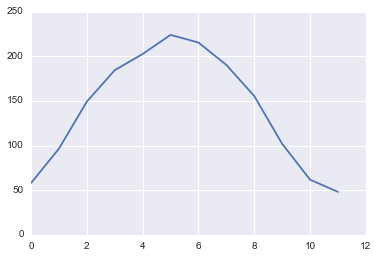

In [34]:
plt.plot(means.loc['ABO']['gre000z0'].values)

# Predict solar power at weather stations

Here, we want to predict the produced solar power at each station by making use of the regression models that we have obtained for the ELL building. 

## Using the model with Irradiance only

Let's start looking at the first model that we trained, based on the irradiance measurements only.

In [36]:
model = pickle.load(open('model.p', 'rb'))

In [37]:
model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

This model returns power in Watt assuming that a total of 14 panels each of 255 W<sub>p</sub> are installed.
However, power potential of a station is defined as the DC power that can be produced at that station with an installation of 1 W<sub>p</sub>. Thus, we normalize it.

In [38]:
normalizingFactor = 14 * 255 # i Wp

And we predict the produced solar power according to the average irradiation in each month at each station.

In [39]:
irradiance_s = means.gre000z0.values

In [41]:
power_s = model.predict(irradiance_s.reshape(-1,1))/normalizingFactor

We add the predicted solar power as a column of the DataFrame.

In [43]:
means['power'] = power_s

In [44]:
means.head(24)

gre000z0     power
stn time                      
ABO 1      58.048460  0.058168
    2      96.532893  0.095815
    3     149.232683  0.147082
    4     184.433614  0.181141
    5     202.537315  0.198600
    6     223.920250  0.219171
    7     215.322667  0.210906
    8     190.238898  0.186744
    9     155.390976  0.153051
    10    101.868912  0.101021
    11     61.735498  0.061782
    12     48.092217  0.048399
AIG 1      53.937064  0.054135
    2      91.366564  0.090771
    3     147.649500  0.145547
    4     190.951733  0.187431
    5     214.986601  0.210583
    6     253.297507  0.247343
    7     240.113136  0.234712
    8     206.868041  0.202771
    9     165.974634  0.163299
    10    105.705504  0.104762
    11     61.668927  0.061717
    12     44.891603  0.045257

We store this final DataFrame providing the monthly average power produced at each station based on irradiance measures only.

In [61]:
pickle.dump(means, open('groupedStations.p', 'wb'))

## Using the model with Irradiance, Temperature and Wind

Now we repeat the previous steps for the model that we trained using not only irradiance, but also temperature and wind measurements.

In [55]:
model2 = pickle.load(open('model_with_temp_wind.p', 'rb'))

In [56]:
normalizingFactor = 14 * 255 # Wp

In [57]:
allFeatures_df = pickle.load(open('all_features.p','rb'))

In [58]:
allFeatures_df.head()

Irradiance      Temp      Wind
stn time                                
ABO 1      58.652412  1.335902  6.267113
    2      97.041357  1.268299  5.433493
    3     149.705309  3.154173  6.388994
    4     184.841352  5.838967  6.862268
    5     202.885559  9.307222  7.174839

In [63]:
X = allFeatures_df.values

In [64]:
power = model2.predict(X) / normalizingFactor

In [65]:
allFeatures_df['power'] = power

And we store it as well.

In [80]:
pickle.dump(allFeatures_df, open('groupedStationsAllFeatures.p', 'wb'))

Now, we can predict that for each of the following years, we have such average power produced per month at each station and so we can estimate interesting quantities, such as the user's investment, her total savings and the break-even time.